## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from utils import load_3d_data, load_data
import numpy as np

def get_data(num_training=27709, num_validation=1000, num_pub_test=1000, num_pri_test=1000):
    """
    Load the dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test = load_3d_data()

    return X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_pub_test, y_pub_test
   del X_pri_test, y_pri_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
#X_train, y_train, X_val, y_val, X_pub_test, y_pub_test, X_pri_test, y_pri_test = get_data()
X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test = get_data()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
# print('Validation data shape: ', X_val.shape)
# print('Validation labels shape: ', y_val.shape)
print('Public test data shape: ', X_pub_test.shape)
print('Public test labels shape: ', y_pub_test.shape)
print('Private test data shape: ', X_pri_test.shape)
print('Private test labels shape: ', y_pri_test.shape)

Train data shape:  (28709, 48, 48, 3)
Train labels shape:  (28709,)
Public test data shape:  (3589, 48, 48, 3)
Public test labels shape:  (3589,)
Private test data shape:  (3589, 48, 48, 3)
Private test labels shape:  (3589,)


In [3]:
X_train[999].shape

(48, 48, 3)

6


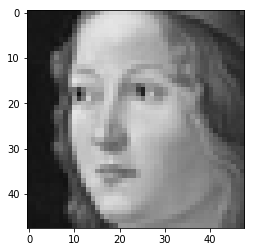

In [4]:
print(y_train[999])
plt.imshow(X_train[999]);

In [5]:
num_classes = 7

y_train = keras.utils.to_categorical(y_train, num_classes)
y_pub_test = keras.utils.to_categorical(y_pub_test, num_classes)
y_pri_test = keras.utils.to_categorical(y_pri_test, num_classes)

In [6]:
y_train[444]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [7]:
# As before, let's make everything float and scale
X_train = X_train.astype('float32')
X_pub_test = X_pub_test.astype('float32')
X_pri_test = X_pri_test.astype('float32')

X_train /= 255
X_pub_test /= 255
X_pri_test /= 255

In [8]:
# Please provide your solution here
# Create model_2 as mentioned in the exercise
# Let's build a CNN using Keras' Sequential capabilities
from keras.layers.normalization import BatchNormalization
from keras import models, layers
from keras.models import Model
#Instantiate an empty model
base_model = ResNet50(include_top = False, weights = None,
  input_tensor = None, input_shape = (48, 48, 3), pooling = 'None')

#for layer in base_model.layers:
#    layer.trainable = False

num_classes = 7

x = Flatten()(base_model.output)
x = Dense(400, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

batch_size = 128

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\jstndlee\Anaconda3\envs\cecs551-project-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
rate = 3e-5

# initiate RMSprop optimizer
#opt = keras.optimizers.rmsprop(lr=rate, decay=1e-6)
opt = keras.optimizers.Adam(lr=rate, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

print('Learning rate: %f' % rate)
loss = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=240,
              validation_data=(X_pub_test, y_pub_test),
              shuffle=True,
              verbose=1)
score = model.evaluate(X_pri_test, y_pri_test, verbose=0)

Learning rate: 0.000030
Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 3589 samples
Epoch 1/240
28709/28709 [==============================] - 72s 3ms/step - loss: 2.4955 - acc: 0.1509 - val_loss: 2.0536 - val_acc: 0.1683
Epoch 2/240
28709/28709 [==============================] - 58s 2ms/step - loss: 2.3767 - acc: 0.1633 - val_loss: 1.9830 - val_acc: 0.1847
Epoch 3/240
28709/28709 [==============================] - 60s 2ms/step - loss: 2.3052 - acc: 0.1685 - val_loss: 1.9695 - val_acc: 0.1856
Epoch 4/240
28709/28709 [==============================] - 59s 2ms/step - loss: 2.2589 - acc: 0.1768 - val_loss: 1.9481 - val_acc: 0.2120
Epoch 5/240
28709/28709 [==============================] - 59s 2ms/step - loss: 2.2154 - acc: 0.1835 - val_loss: 1.9860 - val_acc: 0.2157
Epoch 6/240
28709/28709 [==============================] - 59s 2ms/step - loss: 2.1801 - acc: 0.1906 - val_loss: 1.9147 - val_acc: 0.2561
Epoch 7/240
28709/28709 [==========================

28709/28709 [==============================] - 56s 2ms/step - loss: 0.2987 - acc: 0.9187 - val_loss: 2.5728 - val_acc: 0.3494
Epoch 58/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.2877 - acc: 0.9212 - val_loss: 2.5261 - val_acc: 0.3452
Epoch 59/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.2912 - acc: 0.9177 - val_loss: 2.5829 - val_acc: 0.3463
Epoch 60/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.2795 - acc: 0.9220 - val_loss: 2.6297 - val_acc: 0.3508
Epoch 61/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.2568 - acc: 0.9298 - val_loss: 2.6237 - val_acc: 0.3589
Epoch 62/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.2956 - acc: 0.9179 - val_loss: 2.6736 - val_acc: 0.3541
Epoch 63/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.2487 - acc: 0.9329 - val_loss: 2.6167 - val_acc: 0.3578
Epoch 64/240
28709/28709 [==============

Epoch 116/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0984 - acc: 0.9743 - val_loss: 3.1175 - val_acc: 0.3706
Epoch 117/240
28709/28709 [==============================] - 57s 2ms/step - loss: 0.0916 - acc: 0.9754 - val_loss: 3.1476 - val_acc: 0.3831
Epoch 118/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0847 - acc: 0.9774 - val_loss: 3.2129 - val_acc: 0.3745
Epoch 119/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.1010 - acc: 0.9730 - val_loss: 3.1910 - val_acc: 0.3959
Epoch 120/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.1018 - acc: 0.9735 - val_loss: 3.1286 - val_acc: 0.3789
Epoch 121/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0940 - acc: 0.9761 - val_loss: 3.1587 - val_acc: 0.3837
Epoch 122/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0868 - acc: 0.9773 - val_loss: 3.2253 - val_acc: 0.3700
Epoch 123/240
28709/

28709/28709 [==============================] - 56s 2ms/step - loss: 0.0579 - acc: 0.9837 - val_loss: 3.3519 - val_acc: 0.3973
Epoch 175/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0581 - acc: 0.9847 - val_loss: 3.2913 - val_acc: 0.4029
Epoch 176/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0524 - acc: 0.9855 - val_loss: 3.3632 - val_acc: 0.3979
Epoch 177/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0513 - acc: 0.9858 - val_loss: 3.4277 - val_acc: 0.4007
Epoch 178/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0671 - acc: 0.9814 - val_loss: 3.3825 - val_acc: 0.4001
Epoch 179/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0837 - acc: 0.9759 - val_loss: 3.2915 - val_acc: 0.3951
Epoch 180/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0627 - acc: 0.9832 - val_loss: 3.2111 - val_acc: 0.3979
Epoch 181/240
28709/28709 [=======

28709/28709 [==============================] - 56s 2ms/step - loss: 0.0425 - acc: 0.9880 - val_loss: 3.4039 - val_acc: 0.4199
Epoch 233/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0414 - acc: 0.9891 - val_loss: 3.3618 - val_acc: 0.4149
Epoch 234/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0416 - acc: 0.9881 - val_loss: 3.3971 - val_acc: 0.4107
Epoch 235/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0461 - acc: 0.9866 - val_loss: 3.2842 - val_acc: 0.4216
Epoch 236/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0483 - acc: 0.9857 - val_loss: 3.3806 - val_acc: 0.4171
Epoch 237/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0405 - acc: 0.9889 - val_loss: 3.3357 - val_acc: 0.4260
Epoch 238/240
28709/28709 [==============================] - 56s 2ms/step - loss: 0.0382 - acc: 0.9886 - val_loss: 3.6170 - val_acc: 0.3965
Epoch 239/240
28709/28709 [=======

In [10]:
print('Learning rate:', rate)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Learning rate: 3e-05
Test loss: 3.419088823910243
Test accuracy: 0.4028977431371438


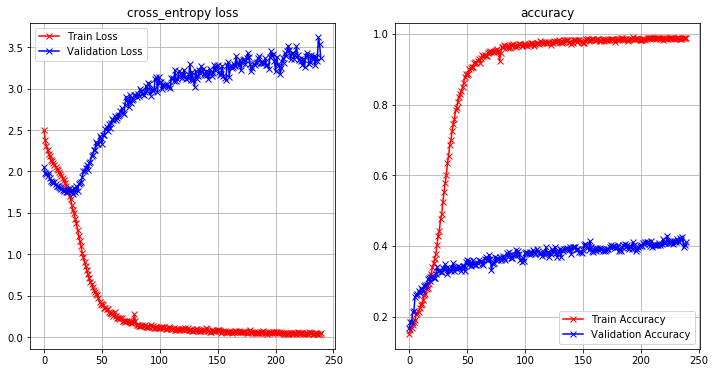

In [11]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
    

plot_loss_accuracy(loss)

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

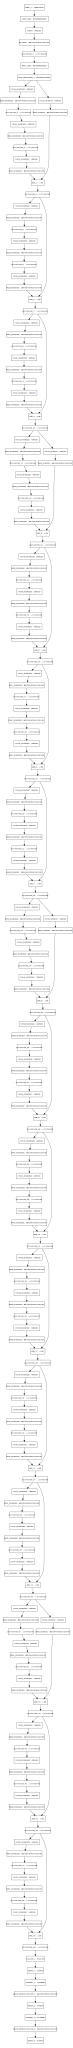

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

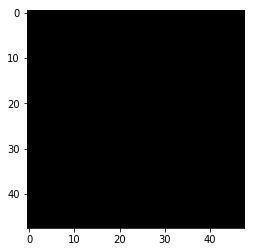

(1, 48, 48, 3)


In [14]:
from keras.preprocessing import image

img_tensor = image.img_to_array(X_train[999])
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [15]:

from keras import models
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
img_tensor = np.expand_dims(X_train[0], axis=0)
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation
classes = classifier.predict_classes(img_tensor, batch_size=1)
print("Predicted class is:",classes)
layer_names = []
for layer in classifier.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

InvalidArgumentError: input_1:0 is both fed and fetched.